In [ ]:
!pip install llama-index transformers huggingface-hub
!pip install llama-index-llms-huggingface
!pip install llama-index-embeddings-huggingface
!pip install python-dotenv

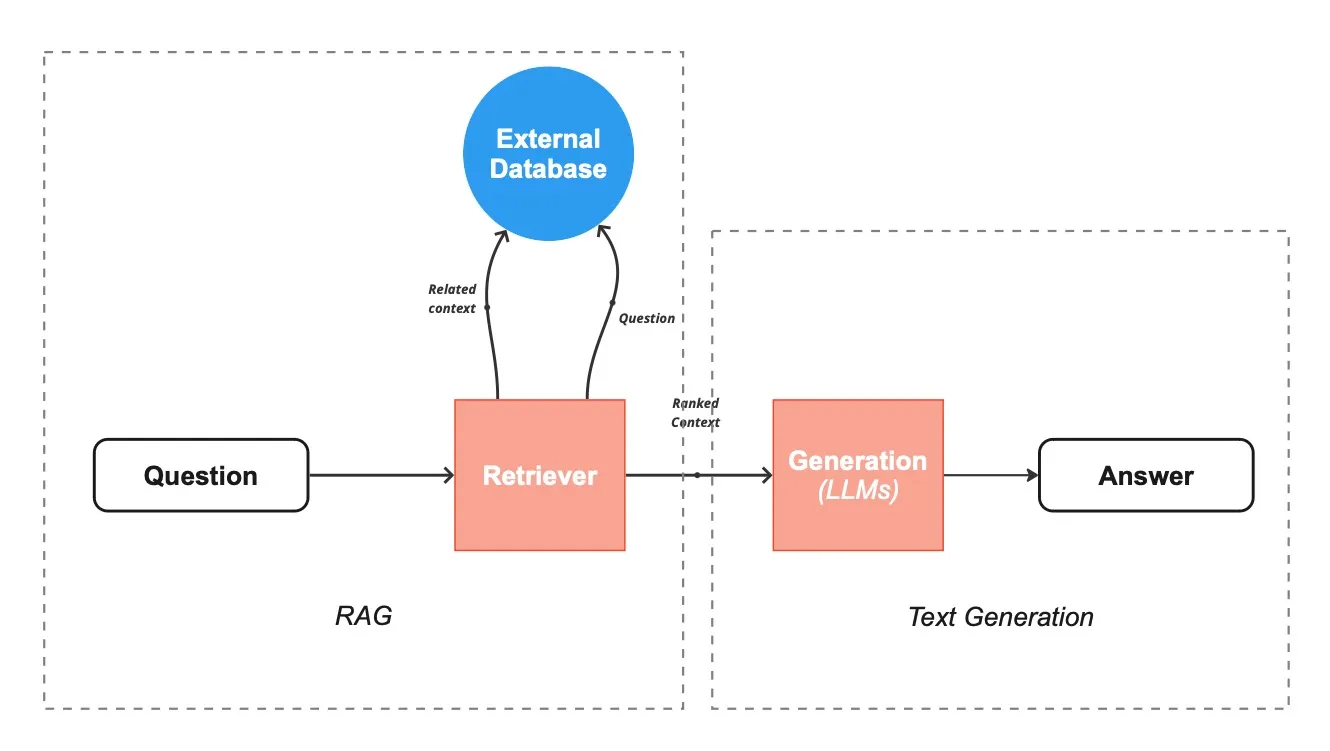

# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from llama_index.llms.huggingface import HuggingFaceInferenceAPI
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import SimpleDirectoryReader
from llama_index.core import VectorStoreIndex


# Get API token

In [ ]:
from dotenv import load_dotenv
import os

In [ ]:
load_dotenv('.env')


# Prompt

In [ ]:

def completion_to_prompt(completion):
    return f"\n</s>\n\n{completion}</s>\n\n"

def messages_to_prompt(messages):
    prompt = ""
    for message in messages:
        prompt += f"\n{message.content}</s>\n"

    if not prompt.startswith("\n"):
        prompt = "\n</s>\n" + prompt

    prompt = prompt + "\n"
    return prompt

# Set Model and Embeddings

In [ ]:
Settings.embed_model = HuggingFaceEmbedding(
    model_name = 'sentence-transformers/all-MiniLM-L6-v2',
)

Settings.llm = HuggingFaceInferenceAPI(
    # model_name="HuggingFaceH4/zephyr-7b-beta",
    model_name="mistralai/Mistral-7B-Instruct-v0.3",
    token=token,
    context_window=3900,
    max_new_tokens=256,
    generate_kwargs={"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
    device_map="auto",
)

# Load Data

In [ ]:
documents = SimpleDirectoryReader('data/pdf2/').load_data()
print(documents)
print(len(documents))
index = VectorStoreIndex.from_documents(documents)

# Set your RAG based System

In [ ]:
query_engine = index.as_query_engine()

# Query Function

In [ ]:
def query_llm(query):
    response = query_engine.query(query)
    return response, query

In [ ]:
def format_output(answer, query):
    result = f"**Question:** {query}\n\n"
    result += f"**Answer:** \n{answer.response}\n\n"

    if answer.source_nodes:
        result += "You can read more of it at: \n"
        for node in answer.source_nodes:
            # Extracting metadata
            metadata = node.node.metadata
            page = metadata.get('page_label', 'N/A')
            source = metadata.get('file_name', 'N/A')

            # Formatting the source information
            result += f"- Page {page} from {source}\n"
        result += "\n"

    return result

# Query

In [ ]:
user_input = "What is the paper about?"

In [ ]:
response, query = query_llm(user_input)
formatted_output = format_output(response, query)
print(formatted_output)